In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define target year for filtering
target_year = 2015  # Set your desired year here

# Load data from CSV
data = pd.read_csv('/content/stock_data2.csv')
filtered_data = data[(data['Year'] <= target_year) &
                     (data['Net Sales'] >= 200) &
                     (data['Reported Profit After Tax'] >= 10)]

# Function to forecast metrics for each ticker
def process_ticker(ticker_data):
    # Extract metrics
    net_sales = ticker_data['Net Sales'].values
    profit_after_tax = ticker_data['Reported Profit After Tax'].values

    # Function to forecast the next two years
    def forecast_metric(y):
        # Remove NaNs and prepare X
        y_clean = y[~np.isnan(y)]

        if len(y_clean) < 2:  # Ensure there's enough data for polynomial regression
            return [y_clean[-1] if len(y_clean) > 0 else None, y_clean[-1] if len(y_clean) > 0 else None]

        # Prepare the years for X based on the available data points
        X = np.arange(len(y_clean)).reshape(-1, 1)  # Corresponds to indices of available data

        # Fit the model
        model = LinearRegression()
        poly = PolynomialFeatures(degree=2)  # Change degree if needed
        X_poly = poly.fit_transform(X)

        # Fit the model using the valid data
        model.fit(X_poly, y_clean)

        # Prepare to predict for the next two years
        future_years = np.array([[len(y_clean)], [len(y_clean) + 1]])  # Predict for the next two years
        future_years_poly = poly.transform(future_years)

        predictions = model.predict(future_years_poly)
        return predictions

    # Forecast metrics for the next two years
    forecasted_net_sales = forecast_metric(net_sales)
    forecasted_profit_after_tax = forecast_metric(profit_after_tax)

    # Check if target year data exists
    target_year_data = ticker_data[ticker_data['Year'] == target_year]
    if target_year_data.empty:
        return None  # Skip if target year data is missing

    target_year_data = target_year_data.iloc[0]  # Get the first row if multiple exist

    # Prepare results including the target year row
    forecast_data = {
        'NSE Symbol': [target_year_data['NSE Symbol']] * 3,
        'Year': [target_year, target_year + 1, target_year + 2],
        'Net Sales': [target_year_data['Net Sales']] + list(forecasted_net_sales),
        'Reported Profit After Tax': [target_year_data['Reported Profit After Tax']] + list(forecasted_profit_after_tax)
    }

    return pd.DataFrame(forecast_data)

# Group by NSE Symbol and process each
results = filtered_data.groupby('NSE Symbol', group_keys=False).apply(process_ticker).reset_index(drop=True)
results = results.dropna()  # Drop any empty rows if a symbol has no data

# Save to CSV
results.to_csv('forecast.csv', index=False)

print("Results saved to forecast.csv.")


Results saved to forecast.csv.


<ipython-input-98-446ae0c7d42c>:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = filtered_data.groupby('NSE Symbol', group_keys=False).apply(process_ticker).reset_index(drop=True)


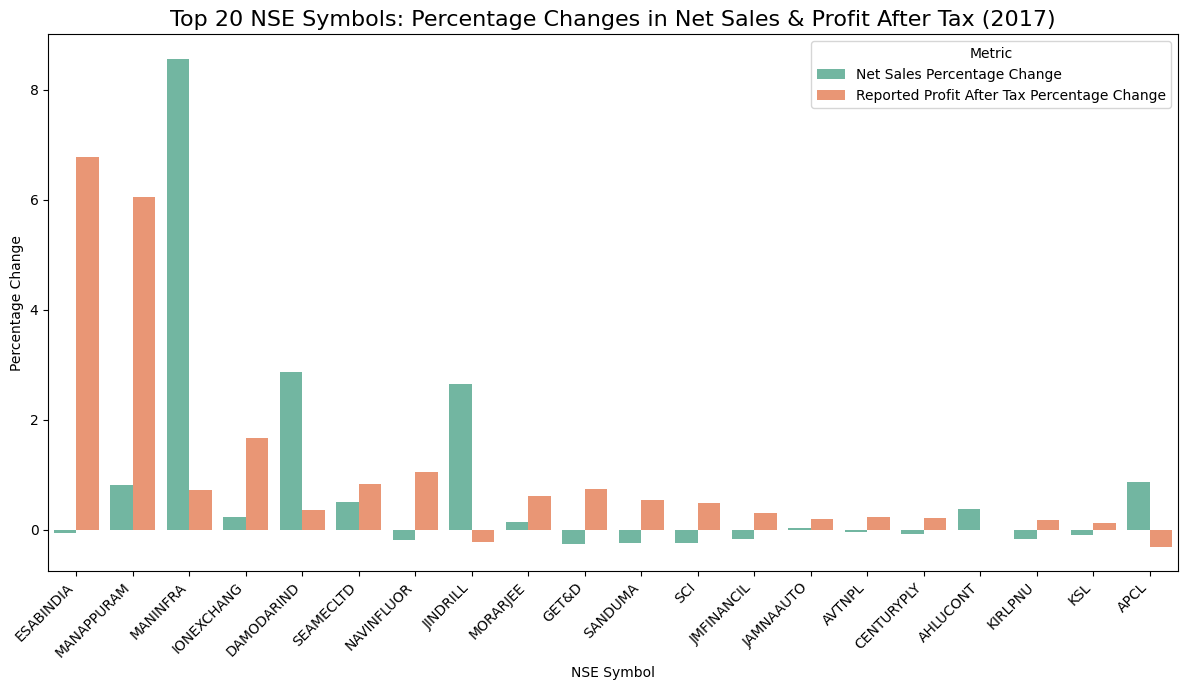

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the forecasted results from the Excel file
data = pd.read_csv('/content/forecast.csv')

# Step 2: Filter data for 2021 and 2022
data_2022 = data[data['Year'] == 2015]
data_2021 = data[data['Year'] == 2016]

# Step 3: Merge the 2021 and 2022 data based on NSE Symbol (to compare metrics)
data_merged = pd.merge(data_2022[['NSE Symbol', 'Net Sales', 'Reported Profit After Tax']],
                       data_2021[['NSE Symbol', 'Net Sales', 'Reported Profit After Tax']],
                       on='NSE Symbol', suffixes=('_2022', '_2021'))

# Step 4: Drop rows where any column ('Net Sales' or 'Reported Profit After Tax') is negative in 2022 or 2021
data_merged = data_merged[(data_merged['Net Sales_2022'] >= 0) & (data_merged['Reported Profit After Tax_2022'] >= 0)]
data_merged = data_merged[(data_merged['Net Sales_2021'] >= 0) & (data_merged['Reported Profit After Tax_2021'] >= 0)]

# Step 5: Drop rows where the 'Reported Profit After Tax' in 2022 is less than 2021 (decreasing profit)
data_merged = data_merged[data_merged['Reported Profit After Tax_2022'] >= data_merged['Reported Profit After Tax_2021']]

# Step 6: Calculate the percentage change for each metric (compared to 2021)
def safe_percentage_change(new_value, old_value):
    """Handles negative and zero values in the percentage change calculation."""
    if old_value == 0:  # Avoid division by zero for percentage change
        return np.nan  # We return NaN if there's no previous data to compare (e.g., for new entries)
    return (new_value - old_value) / old_value * 100

data_merged['Net Sales Percentage Change'] = data_merged.apply(
    lambda row: safe_percentage_change(row['Net Sales_2022'], row['Net Sales_2021']), axis=1)

data_merged['Reported Profit After Tax Percentage Change'] = data_merged.apply(
    lambda row: safe_percentage_change(row['Reported Profit After Tax_2022'], row['Reported Profit After Tax_2021']), axis=1)

# Step 7: Handle NaN values (e.g., for missing data)
data_merged = data_merged.fillna(0)

# Step 8: Drop rows where either 'Net Sales Percentage Change' or 'Reported Profit After Tax Percentage Change' is negative
data_merged = data_merged[data_merged['Net Sales Percentage Change'] >= 0]
data_merged = data_merged[data_merged['Reported Profit After Tax Percentage Change'] >= 0]

# Step 9: Standardize the percentage changes (so both metrics are on the same scale)
scaler = StandardScaler()
data_merged[['Net Sales Percentage Change', 'Reported Profit After Tax Percentage Change']] = scaler.fit_transform(
    data_merged[['Net Sales Percentage Change', 'Reported Profit After Tax Percentage Change']]
)

# Step 10: Apply a weighted score to the percentage change metrics
weights = {'Net Sales Percentage Change': 0.3, 'Reported Profit After Tax Percentage Change': 0.7}

data_merged['Weighted Score'] = (
    data_merged['Net Sales Percentage Change'] * weights['Net Sales Percentage Change'] +
    data_merged['Reported Profit After Tax Percentage Change'] * weights['Reported Profit After Tax Percentage Change']
)

# Step 11: Rank companies based on the Weighted Score (higher score = better rank)
data_merged['Rank'] = data_merged['Weighted Score'].rank(ascending=False)

# Step 12: Sort by Rank to get the best-ranked companies
data_sorted = data_merged.sort_values('Rank')

# Step 14: Visualize the results

# Bar plot for the Percentage Changes in Net Sales and Profit After Tax for the top 10 companies
plt.figure(figsize=(12, 7))
top_10_melted = data_sorted.head(20).melt(id_vars=["NSE Symbol"], value_vars=["Net Sales Percentage Change", "Reported Profit After Tax Percentage Change"],
                                          var_name="Metric", value_name="Percentage Change")
sns.barplot(x="NSE Symbol", y="Percentage Change", hue="Metric", data=top_10_melted, palette="Set2")
plt.title('Top 20 NSE Symbols: Percentage Changes in Net Sales & Profit After Tax (2017)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()